In [73]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
import pickle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
from abc import ABC, abstractmethod

from cubic_subproblem_solver import *

# Helper functions

In [74]:
# TODO: check cubic_subproblem_solver
# TODO: cubic_subproblem_solver with tensors
# TODO: add seed (can we do it outside of a class?)
# TODO: check how often do we encounter degenerate case in CN
# TODO: all methods with constant and adaptive step size
# TODO: evaluate spectrum more frequently than hessian (because we can)
# TODO: save_hessian_every

In [75]:
def get_principal_vecs(X, new_dim):
    assert new_dim <= X.shape[1]
    sigma, V = torch.linalg.eigh(X.T @ X)
    princ_vecs = V[:,-new_dim:]
    return princ_vecs


def load_and_transform_mnist(new_dim):
    mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
    mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
    
    X_train = mnist_trainset.data.reshape(-1,28*28) / 255.
    y_train = mnist_trainset.targets
    X_test = mnist_testset.data.reshape(-1,28*28) / 255.
    y_test = mnist_testset.targets
    
    princ_vecs = get_principal_vecs(X_train, new_dim)
    X_train = X_train @ princ_vecs
    X_test = X_test @ princ_vecs
    
    mnist_dataset = {
        "train_data": X_train,
        "train_targets": y_train,
        "test_data": X_test,
        "test_targets": y_test
    }
    
    return mnist_dataset


def transform_labels_to_binary(labels):
    return torch.tensor(list(map(lambda x: 0 if x<5 else 1, labels)))


class LogisticNet(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)


class MLP(nn.Module):
    
    def __init__(self, dims, activation):
        super().__init__()
        assert len(dims) >= 2
        self.activation = activation
        self.n_layers = len(dims) - 1
        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[self.n_layers - 1](x)


In [76]:
def print_training_stats(trainer):
    iters = trainer.metrics["iter"] + trainer.hessian_metrics["iter"]
    iters = sorted(list(set(iters)))
    for i in iters:
        trainer.print_training_stats(i)

def get_metrics(trainer):
    metrics = trainer.metrics.copy()
    for key, value in metrics.items():
        metrics[key] = np.array(value)
    return metrics

def get_hessian_metrics(trainer):
    hessian_metrcis = {
        "iter": np.array(trainer.hessian_metrics["iter"].copy()),
        "lambda_1": np.array([spec[-1] for spec in trainer.hessian_metrics["spectrum"]]),
        "lambda_n": np.array([spec[0] for spec in trainer.hessian_metrics["spectrum"]]),
    }
    return hessian_metrcis

In [77]:
import plotly.graph_objects as go

def visualize_spectrum_evolution(trainer):
    fig = go.Figure()
    
    #check that have something to plot
    assert len(trainer.hessian_metrics["iter"]) > 0
    
    n_params = trainer.hessian_metrics["spectrum"][0].shape[0]
    
    for i in range(len(trainer.hessian_metrics["iter"])):
        fig.add_trace(
        go.Histogram(
            visible=False,
            nbinsx = n_params,
            x = trainer.hessian_metrics["spectrum"][i],
            #alignmentgroup = True
        )
    )
    
    fig.data[0].visible = True
    
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "Iter: " + str(trainer.hessian_metrics["iter"][i])}]
        )
        step["args"][0]["visible"][i] = True
        steps.append(step)
    
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Iter: "},
        pad={"t": 50},
        steps=steps
    )]
    
    eig_min = min([min(spectrum) for spectrum in trainer.hessian_metrics["spectrum"]])
    eig_max = max([max(spectrum) for spectrum in trainer.hessian_metrics["spectrum"]])
    
    fig.update_layout(
        sliders=sliders,
        xaxis_range=[eig_min-0.1, eig_max+0.1]
    )

    fig.show()


def visualize_hessians_evolution(trainer):
    fig = go.Figure()
    
    #check that have something to plot
    assert len(trainer.hessian_metrics["hessian_iter"]) > 0
    
    n_params = trainer.hessian_metrics["hessian"][0].shape[0]
    
    for i in range(len(trainer.hessian_metrics["hessian_iter"])):
        fig.add_trace(
        go.Heatmap(
            visible=False,
            #x = np.arange(n_params),
            #y = np.arange(n_params),
            z = trainer.hessian_metrics["hessian"][i]
        )
    )
    
    fig.data[0].visible = True
    
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "Iter: " + str(trainer.hessian_metrics["hessian_iter"][i])}]
        )
        step["args"][0]["visible"][i] = True
        steps.append(step)
    
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Iter: "},
        pad={"t": 50},
        steps=steps
    )]
    
    fig.update_layout(
        sliders=sliders,
        width=600,
        height=600
    )

    fig.show()

# Abstract class Trainer

In [78]:
class Trainer(ABC):
    
    def __init__(self, model, dataset, criterion, model_dir):
        
        self.model = model
        self.dataset = dataset
        self.criterion = criterion
        
        self.MODEL_DIR = model_dir
        self.iter = 0
        self.init_params = None # parameters of the model at the start of the training
        self.prev_params = None # parameters at the previous step
        
        # TODO: add step distance, distance from start
        self.metrics = {
            "train_loss": [],
            "test_loss": [],
            "train_acc": [],
            "test_acc": [],
            "grad_norm": [],
            "step_size": [],
            "dist_from_start": [],
            "time": [],
            "iter": [],
        }
        
        self.hessian_metrics = {
            "spectrum": [],
            "hessian": [],
            "iter": [],
            "hessian_iter": [],
        }
    
    def get_metadata(self):
        return {
            "iter": self.iter,
            "init_params": self.init_params,
            "prev_params": self.prev_params,
        }
    
    def update_metadata(self, new_metadata):
        self.iter = new_metadata["iter"]
        self.init_params = new_metadata["init_params"]
        self.prev_params = new_metadata["prev_params"]
    
    def save(self):
        if not os.path.isdir(self.MODEL_DIR):
            os.makedirs(self.MODEL_DIR)
        torch.save(self.model.state_dict(), os.path.join(self.MODEL_DIR, "model"))
        with open(os.path.join(self.MODEL_DIR, "metrics"), "wb") as f:
            pickle.dump(self.metrics, f)
        with open(os.path.join(self.MODEL_DIR, "hessian_metrics"), "wb") as f:
            pickle.dump(self.hessian_metrics, f)
        metadata = self.get_metadata()
        with open(os.path.join(self.MODEL_DIR, "metadata"), "wb") as f:
            pickle.dump(metadata, f)
    
    def load(self):
        self.model.load_state_dict(torch.load(os.path.join(self.MODEL_DIR, "model")))
        with open(os.path.join(self.MODEL_DIR, "metrics"), "rb") as f:
            self.metrics = pickle.load(f)
        with open(os.path.join(self.MODEL_DIR, "hessian_metrics"), "rb") as f:
            self.hessian_metrics = pickle.load(f)
        with open(os.path.join(self.MODEL_DIR, "metadata"), "rb") as f:
            metadata = pickle.load(f)
        self.update_metadata(metadata)
    
    def evaluate(self, X, y):
        with torch.no_grad():
            preds = self.model(X)
            loss = self.criterion(preds, y)
            preds = torch.argmax(preds, axis=1)
            acc = torch.mean((preds == y).float())
        return loss.item(), acc.item()
    
    def calculate_grad_norm_squared(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        self.model.zero_grad()
        loss.backward()
        grad_norm = sum([p.grad.pow(2).sum().item() for p in self.model.parameters()])
        return grad_norm
    
    def calculate_hessian(self, X, y):
        
        def calculate_loss(*params):
            assert len(params) % 2 == 0
            n_layers = len(params) // 2
            preds = X
            for i in range(n_layers):
                preds = preds @ params[2*i].T + params[2*i+1]
            return self.criterion(preds, y)

        params = tuple([p.data for p in self.model.parameters()])
        hessians = torch.autograd.functional.hessian(calculate_loss, params)
        
        hessians = list(hessians)
        n = len(hessians)
        for i in range(n):
            hessians[i] = list(hessians[i])

        params_numels = [p.data.numel() for p in self.model.parameters()]

        for i in range(n):
            for j in range(n):
                hessians[i][j] = hessians[i][j].reshape(params_numels[i], params_numels[j])
            hessians[i] = torch.cat(hessians[i], axis=1)

        hessians = torch.cat(hessians, axis=0)

        return hessians
    
    def params_dist(self, another_model_params):
        return math.sqrt(sum([(p - p_another).pow(2).sum() for p, p_another in 
                              zip(self.model.parameters(), another_model_params)]))
    
    def update_metrics(self, training_time):
        train_loss, train_acc = self.evaluate(self.dataset["train_data"], self.dataset["train_targets"])
        test_loss, test_acc = self.evaluate(self.dataset["test_data"], self.dataset["test_targets"])
        
        grad_norm = math.sqrt(self.calculate_grad_norm_squared(
            self.dataset["train_data"], self.dataset["train_targets"]))
        
        step_size = None if self.iter == 0 else self.params_dist(self.prev_params)
        dist_from_start = self.params_dist(self.init_params)
        
        self.metrics["train_loss"].append(train_loss)
        self.metrics["test_loss"].append(test_loss)
        self.metrics["train_acc"].append(train_acc)
        self.metrics["test_acc"].append(test_acc)
        self.metrics["grad_norm"].append(grad_norm)
        self.metrics["step_size"].append(step_size)
        self.metrics["dist_from_start"].append(dist_from_start)
        self.metrics["time"].append(training_time)
        self.metrics["iter"].append(self.iter)
        
        self.prev_params = None
    
    def update_hessian_metrics(self, save_hessian_every, hessian=None):
        if hessian is None:
            hessian = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
        hessian = hessian.numpy()
        spectrum = np.linalg.eigvalsh(hessian)
        self.hessian_metrics["spectrum"].append(spectrum)
        self.hessian_metrics["iter"].append(self.iter)
        if (save_hessian_every is not None) and (self.iter % save_hessian_every == 0):
            self.hessian_metrics["hessian"].append(hessian)
            self.hessian_metrics["hessian_iter"].append(self.iter)
    
    @abstractmethod
    def print_training_stats(self, iteration):
        pass
    
    def prepare_training(self, eval_every, eval_hessian_every, save_hessian_every):
        # calculate metrics for initial model state
        self.init_params = [p.data.clone() for p in self.model.parameters()]
        if eval_every is not None:
            self.update_metrics(training_time=0.0)
        if eval_hessian_every is not None:
            self.update_hessian_metrics(save_hessian_every)
    
    @abstractmethod
    def perform_training_loop(self, max_iters, print_every, eval_every, eval_hessian_every,
                              save_hessian_every, save_every):
        pass
    
    def train(self, max_iters, print_every=None, eval_every=None, eval_hessian_every=None,
              save_hessian_every=None, save_every=None):
        # every time we want to print metrics, it must be evaluated
        assert (print_every is None) or ((eval_every is not None) and (print_every % eval_every == 0))
        # every time we evaluate hessian metrics, we must also evaluate simple metrics
        assert (eval_hessian_every is None) or ((eval_every is not None) and (eval_hessian_every % eval_every == 0))
        # every time we save hessian, it must be evaluated
        assert (save_hessian_every is None) or ((eval_hessian_every is not None) and (save_hessian_every % eval_hessian_every == 0))

        if self.iter == 0:
            self.prepare_training(eval_every, eval_hessian_every, save_hessian_every)
        
        if print_every is not None:
            self.print_training_stats(self.iter)
        
        self.perform_training_loop(max_iters, print_every, eval_every, eval_hessian_every,
                                   save_hessian_every, save_every)

        return self.metrics.copy(), self.hessian_metrics.copy()

# GD with adaptive L as child class

In [79]:
class AdaptiveGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, model_dir, L_0, L_min):
        
        super().__init__(model, dataset, criterion, model_dir)
        self.L = L_0
        self.L_min = L_min
        self.metrics["L"] = []
    
    def get_metadata(self):
        metadata = super().get_metadata()
        metadata["L"] = self.L
        metadata["L_min"] = self.L_min
        return metadata
    
    def update_metadata(self, new_metadata):
        super().update_metadata(new_metadata)
        self.L = new_metadata["L"]
        self.L_min = new_metadata["L_min"]
    
    def update_metrics(self, training_time):
        super().update_metrics(training_time)
        self.metrics["L"].append(self.L)
    
    def print_training_stats(self, iteration):
        try:
            iter_id = self.metrics["iter"].index(iteration)
            print(f'{self.metrics["iter"][iter_id]:>6,d}: train loss = {self.metrics["train_loss"][iter_id]:>9.6f}, \
L = {self.metrics["L"][iter_id]:>8.3f}, time = {self.metrics["time"][iter_id]:>7.2f} sec', end='')
        except:
            pass
        try:
            iter_id = self.hessian_metrics["iter"].index(iteration)
            print(f', lambda_n = {self.hessian_metrics["spectrum"][iter_id][0]:>12.6f}', end='')
        except:
            pass
        print()
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def set_params(self, another_model, new_params):
        for p, d in zip(another_model.parameters(), new_params):
            p.data = d
    
    def perform_training_loop(self, max_iters, print_every, eval_every, eval_hessian_every,
                              save_hessian_every, save_every):
        total_time = self.metrics["time"][-1]
        start_time = time.perf_counter()
        
        while self.iter < max_iters:
            
            if (eval_every is not None) and ((self.iter+1) % eval_every == 0):
                self.prev_params = [p.data.clone() for p in self.model.parameters()]
            
            outputs = self.model(self.dataset["train_data"])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"])
            loss.backward()
            grad_norm_squared = sum([p.grad.pow(2).sum().item() for p in self.model.parameters()])
            model_next = copy.deepcopy(self.model)
            new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
            self.set_params(model_next, new_params)
            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                    loss.item() - 1/(2*self.L) * grad_norm_squared):
                self.L *= 2
                new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
                self.set_params(model_next, new_params)
            
            self.set_params(self.model, new_params)
            self.iter += 1
            
            if (eval_every is not None) and (self.iter % eval_every == 0):
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if (eval_hessian_every is not None) and (self.iter % eval_hessian_every == 0):
                    self.update_hessian_metrics(save_hessian_every)
                if (print_every is not None) and (self.iter % print_every == 0):
                    self.print_training_stats(self.iter)
                start_time = time.perf_counter()
            
            self.L = max(self.L / 2, self.L_min)
            
            if (save_every is not None) and (self.iter % save_every == 0):
                total_time += time.perf_counter() - start_time
                self.save()
                start_time = time.perf_counter()
            

# Cubic Newton with adaptive M as child class

In [80]:
class AdaptiveCubicNewtonTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, model_dir, M_0, M_min):
        
        super().__init__(model, dataset, criterion, model_dir)
        self.M = M_0
        self.M_min = M_min
        self.metrics["M"] = []
        
        # placeholder
        self.hessian = None
    
    def get_metadata(self):
        metadata = super().get_metadata()
        metadata["M"] = self.M
        metadata["M_min"] = self.M_min
        metadata["hessian"] = self.hessian
        return metadata
    
    def update_metadata(self, new_metadata):
        super().update_metadata(new_metadata)
        self.M = new_metadata["M"]
        self.M_min = new_metadata["M_min"]
        self.hessian = new_metadata["hessian"]
    
    def update_metrics(self, training_time):
        super().update_metrics(training_time)
        self.metrics["M"].append(self.M)
    
    def update_hessian_metrics(self, save_hessian_every):
        super().update_hessian_metrics(save_hessian_every, self.hessian.clone())
    
    def print_training_stats(self, iteration):
        try:
            iter_id = self.metrics["iter"].index(iteration)
            print(f'{self.metrics["iter"][iter_id]:>6,d}: train loss = {self.metrics["train_loss"][iter_id]:>9.6f}, \
M = {self.metrics["M"][iter_id]:>8.3f}, time = {self.metrics["time"][iter_id]:>7.2f} sec', end='')
        except:
            pass
        try:
            iter_id = self.hessian_metrics["iter"].index(iteration)
            print(f', lambda_n = {self.hessian_metrics["spectrum"][iter_id][0]:>12.6f}', end='')
        except:
            pass
        print()
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    # TODO: check if it works correctly
    def calculate_gradient(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        gradients = torch.autograd.grad(loss, self.model.parameters())
        grad = torch.cat([g.flatten() for g in gradients], dim=0)
        return grad
    
    def quadratic_form(self, loss, grad, hess, M, h):
        return loss + torch.dot(grad,h) + 0.5 * torch.dot(hess @ h, h) + M/6 * torch.linalg.norm(h,2)**3
    
    def update_model_params(self, another_model, delta):
        params_numels = [p.data.numel() for p in another_model.parameters()]
        t = list(torch.split(delta, params_numels))
        for i, p in enumerate(another_model.parameters()):
            p.data += t[i].reshape(p.data.shape)
    
    def prepare_training(self, eval_every, eval_hessian_every, save_hessian_every):
        self.hessian = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
        super().prepare_training(eval_every, eval_hessian_every, save_hessian_every)
    
    def perform_training_loop(self, max_iters, print_every, eval_every, eval_hessian_every,
                              save_hessian_every, save_every):
        total_time = self.metrics["time"][-1]
        start_time = time.perf_counter()
        while self.iter < max_iters:
            
            if (eval_every is not None) and ((self.iter+1) % eval_every == 0):
                self.prev_params = [p.data.clone() for p in self.model.parameters()]
            
            loss = self.calculate_loss(self.model, self.dataset["train_data"], self.dataset["train_targets"])
            grad = self.calculate_gradient(self.dataset["train_data"], self.dataset["train_targets"])
            hess = self.hessian
            h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
            model_next = copy.deepcopy(self.model)
            self.update_model_params(model_next, h)

            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                self.quadratic_form(loss, grad, hess, self.M, h)):
                self.M *= 2
                h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
                for p, p_next in zip(self.model.parameters(), model_next.parameters()):
                    p_next.data = p.data.clone()
                self.update_model_params(model_next, h)

            self.update_model_params(self.model, h)
            self.hessian = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
            self.iter += 1
            
            if (eval_every is not None) and (self.iter % eval_every == 0):
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if (eval_hessian_every is not None) and (self.iter % eval_hessian_every == 0):
                    self.update_hessian_metrics(save_hessian_every)
                if (print_every is not None) and (self.iter % print_every == 0):
                    self.print_training_stats(self.iter)
                start_time = time.perf_counter()
            
            self.M = max(self.M / 2, self.M_min)
            
            if (save_every is not None) and (self.iter % save_every == 0):
                total_time += time.perf_counter() - start_time
                self.save()
                start_time = time.perf_counter()


# SGD with decaying lr as 1/sqrt(t)

In [81]:
class SGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, model_dir, initial_lr, batch_size):
        
        super().__init__(model, dataset, criterion, model_dir)
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.batch_start = None
        self.batch_size = batch_size
        self.perm = None
    
    def get_metadata(self):
        metadata = super().get_metadata()
        metadata["initial_lr"] = self.initial_lr
        metadata["lr"] = self.lr
        metadata["batch_start"] = self.batch_start
        metadata["batch_size"] = self.batch_size
        metadata["permutation"] = self.perm
        return metadata
    
    def update_metadata(self, new_metadata):
        super().update_metadata(new_metadata)
        self.initial_lr = new_metadata["initial_lr"]
        self.lr = new_metadata["lr"]
        self.batch_start = new_metadata["batch_start"]
        self.batch_size = new_metadata["batch_size"]
        self.perm = new_metadata["permutation"]
    
    def print_training_stats(self, iteration):
        try:
            iter_id = self.metrics["iter"].index(iteration)
            print(f'{self.metrics["iter"][iter_id]:>6,d}: train loss = {self.metrics["train_loss"][iter_id]:>9.6f}, \
time = {self.metrics["time"][iter_id]:>7.2f} sec', end='')
        except:
            pass
        try:
            iter_id = self.hessian_metrics["iter"].index(iteration)
            print(f', lambda_n = {self.hessian_metrics["spectrum"][iter_id][0]:>12.6f}', end='')
        except:
            pass
        print()
    
    def prepare_training(self, eval_every, eval_hessian_every, save_hessian_every):
        super().prepare_training(eval_every, eval_hessian_every, save_hessian_every)
        assert self.batch_size <= self.dataset["train_data"].shape[0]
        self.batch_start = 0
        self.perm = torch.arange(self.dataset["train_data"].shape[0])
    
    def perform_training_loop(self, max_iters, print_every, eval_every, eval_hessian_every,
                              save_every, save_hessian_every):
        total_time = self.metrics["time"][-1]
        start_time = time.perf_counter()
        while self.iter < max_iters:
            
            if (eval_every is not None) and ((self.iter+1) % eval_every == 0):
                self.prev_params = [p.data.clone() for p in self.model.parameters()]
            
            batch_end = self.batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][self.perm[self.batch_start:batch_end]])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][self.perm[self.batch_start:batch_end]])
            loss.backward()
            with torch.no_grad():
                for p in self.model.parameters():
                    p.data -= self.lr * p.grad
            self.iter += 1
            
            if (eval_every is not None) and (self.iter % eval_every == 0):
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if (eval_hessian_every is not None) and (self.iter % eval_hessian_every == 0):
                    self.update_hessian_metrics(save_hessian_every)
                if (print_every is not None) and (self.iter % print_every == 0):
                    self.print_training_stats(self.iter)
                start_time = time.perf_counter()
            
            self.lr = self.initial_lr / math.sqrt(self.iter+1)
            if batch_end + self.batch_size <= self.dataset["train_data"].shape[0]:
                self.batch_start = batch_end
            else:
                self.batch_start = 0
                self.perm = torch.randperm(self.dataset["train_data"].shape[0])
            
            if (save_every is not None) and (self.iter % save_every == 0):
                total_time += time.perf_counter() - start_time
                self.save()
                start_time = time.perf_counter()


# Trainer with custom optimizer

In [82]:
class CustomTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, model_dir, OptimizerClass, optimizer_params, batch_size):
        
        super().__init__(model, dataset, criterion, model_dir)
        self.optimizer = OptimizerClass(self.model.parameters(), **optim_params)
        self.batch_start = None
        self.batch_size = batch_size
        self.perm = None
    
    def get_metadata(self):
        metadata = super().get_metadata()
        metadata["batch_start"] = self.batch_start
        metadata["batch_size"] = self.batch_size
        metadata["permutation"] = self.perm
        return metadata
    
    def update_metadata(self, new_metadata):
        super().update_metadata(new_metadata)
        self.batch_start = new_metadata["batch_start"]
        self.batch_size = new_metadata["batch_size"]
        self.perm = new_metadata["permutation"]
    
    def save(self):
        super().save()
        torch.save(self.optimizer.state_dict(), os.path.join(self.MODEL_DIR, "optimizer"))
    
    def load(self):
        super().load()
        self.optimizer.load_state_dict(torch.load(os.path.join(self.MODEL_DIR, "optimizer")))
    
    def print_training_stats(self, iteration):
        try:
            iter_id = self.metrics["iter"].index(iteration)
            print(f'{self.metrics["iter"][iter_id]:>6,d}: train loss = {self.metrics["train_loss"][iter_id]:>9.6f}, \
time = {self.metrics["time"][iter_id]:>7.2f} sec', end='')
        except:
            pass
        try:
            iter_id = self.hessian_metrics["iter"].index(iteration)
            print(f', lambda_n = {self.hessian_metrics["spectrum"][iter_id][0]:>12.6f}', end='')
        except:
            pass
        print()
    
    def prepare_training(self, eval_every, eval_hessian_every, save_hessian_every):
        super().prepare_training(eval_every, eval_hessian_every, save_hessian_every)
        assert self.batch_size <= self.dataset["train_data"].shape[0]
        self.batch_start = 0
        self.perm = torch.arange(self.dataset["train_data"].shape[0])
    
    def perform_training_loop(self, max_iters, print_every, eval_every, eval_hessian_every,
                              save_hessian_every, save_every):
        total_time = self.metrics["time"][-1]
        start_time = time.perf_counter()
        while self.iter < max_iters:
            
            if (eval_every is not None) and ((self.iter+1) % eval_every == 0):
                self.prev_params = [p.data.clone() for p in self.model.parameters()]
            
            batch_end = self.batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][self.perm[self.batch_start:batch_end]])
            self.optimizer.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][self.perm[self.batch_start:batch_end]])
            loss.backward()
            self.optimizer.step()
            self.iter += 1
            
            if self.iter % eval_every == 0:
                total_time += time.perf_counter() - start_time
                self.update_metrics(total_time)
                if (eval_hessian_every is not None) and (self.iter % eval_hessian_every == 0):
                    self.update_hessian_metrics(save_hessian_every)
                if (print_every is not None) and (self.iter % print_every == 0):
                    self.print_training_stats(self.iter)
                start_time = time.perf_counter()
            
            if batch_end + self.batch_size <= self.dataset["train_data"].shape[0]:
                self.batch_start = batch_end
            else:
                self.batch_start = 0
                self.perm = torch.randperm(self.dataset["train_data"].shape[0])
            
            if (save_every is not None) and (self.iter % save_every == 0):
                total_time += time.perf_counter() - start_time
                self.save()
                start_time = time.perf_counter()
            

# Experiments

### Logistic regression

In [11]:
PATH = os.path.join(os.path.join(os.getcwd(), "saved_calc"), "logistic_regression")

if not os.path.isdir(PATH):
    os.makedirs(PATH)

In [12]:
new_dim = 20

net = LogisticNet(new_dim, 10)

loss_function = nn.CrossEntropyLoss()

MIN_TRAIN_LOSS = 0.4153611660003662 # for model = LogisticNet(20,10)
MIN_TEST_LOSS = 0.3710212409496307 # for model = LogisticNet(20,10)

def get_net():
    return copy.deepcopy(net)

def get_dataset():
    return load_and_transform_mnist(new_dim)

In [13]:
model_dir = os.path.join(os.path.join(PATH, "GD"), "v1")
max_iters = 1000
print_every = 10
eval_every = 10
eval_hessian_every = 50
save_hessian_every = 100
save_every = 1000
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

GD_trainer = AdaptiveGDTrainer(get_net(), get_dataset(), loss_function, model_dir, Lipschitz_const, 
                            Lipschitz_const_min)

#_ = GD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_hessian_every, save_every)
GD_trainer.load()
GD_trainer.iter

1000

In [34]:
_ = GD_trainer.train(1000, 50, eval_every, eval_hessian_every, save_hessian_every, 1000)

   400: train loss =  0.417184, L =    0.250, time =   16.40 sec, lambda_n =    -0.000000
   450: train loss =  0.416689, L =    1.000, time =   18.21 sec, lambda_n =    -0.000000
   500: train loss =  0.416357, L =    2.000, time =   20.04 sec, lambda_n =    -0.000000
   550: train loss =  0.416128, L =    0.250, time =   21.75 sec, lambda_n =    -0.000000
   600: train loss =  0.415964, L =    1.000, time =   23.86 sec, lambda_n =    -0.000000
   650: train loss =  0.415846, L =    0.500, time =   26.07 sec, lambda_n =    -0.000000
   700: train loss =  0.415756, L =    1.000, time =   28.40 sec, lambda_n =    -0.000000
   750: train loss =  0.415688, L =    0.500, time =   30.60 sec, lambda_n =    -0.000000
   800: train loss =  0.415636, L =    0.500, time =   32.74 sec, lambda_n =    -0.000000
   850: train loss =  0.415594, L =    0.500, time =   34.92 sec, lambda_n =    -0.000000
   900: train loss =  0.415560, L =    0.250, time =   37.13 sec, lambda_n =    -0.000000
   950: tr

In [83]:
#visualize_hessians_evolution(GD_trainer)

In [84]:
#visualize_spectrum_evolution(GD_trainer)

In [14]:
model_dir = os.path.join(os.path.join(PATH, "CN"), "v1")
max_iters = 20
print_every = 1
eval_every = 1
eval_hessian_every = 1
save_hessian_every = 3
save_every=20
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

CN_trainer = AdaptiveCubicNewtonTrainer(get_net(), get_dataset(), loss_function, model_dir, Lipschitz_const, 
                            Lipschitz_const_min)

#_ = CN_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_hessian_every, save_every)
CN_trainer.load()
CN_trainer.iter

20

In [85]:
#visualize_hessians_evolution(CN_trainer)

In [86]:
#visualize_spectrum_evolution(CN_trainer)

In [15]:
model_dir = os.path.join(os.path.join(PATH, "SGD"), "v1")
max_iters = 1000
print_every = 10
eval_every = 10
eval_hessian_every = 50
save_hessian_every = 100
save_every = 1000
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
b_size = 128

SGD_trainer = CustomTrainer(get_net(), get_dataset(), loss_function, model_dir, optim_class, optim_params, b_size)

#_ = SGD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_hessian_every, save_every)
SGD_trainer.load()
SGD_trainer.iter

1000

In [87]:
#visualize_hessians_evolution(SGD_trainer)

In [88]:
#visualize_spectrum_evolution(SGD_trainer)

In [63]:
CN_metrics = get_metrics(CN_trainer)
GD_metrics = get_metrics(GD_trainer)
SGD_metrics = get_metrics(SGD_trainer)
CN_hessian_metrics = get_hessian_metrics(CN_trainer)
GD_hessian_metrics = get_hessian_metrics(GD_trainer)
SGD_hessian_metrics = get_hessian_metrics(SGD_trainer)

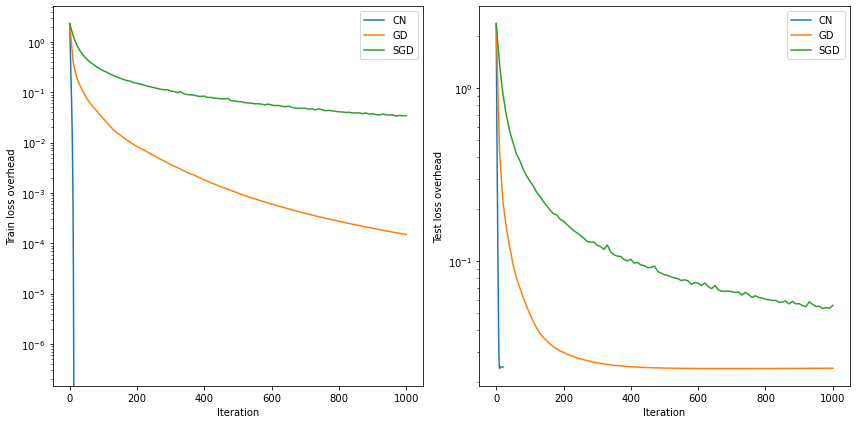

In [64]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_metrics["iter"], CN_metrics["train_loss"] - MIN_TRAIN_LOSS, label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Train loss overhead")
ax.set_yscale('log')
ax.legend()

ax = axes[1]
ax.plot(CN_metrics["iter"], CN_metrics["test_loss"] - MIN_TEST_LOSS, label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["test_loss"] - MIN_TEST_LOSS, label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Test loss overhead")
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
plt.show()

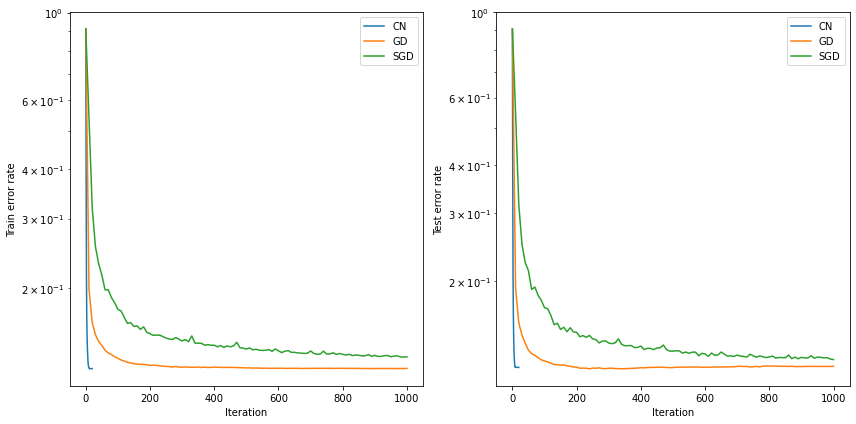

In [65]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax.plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax.plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Train error rate")
ax.set_yscale('log')
ax.legend()

ax = axes[1]
ax.plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax.plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax.plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Test error rate")
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
plt.show()

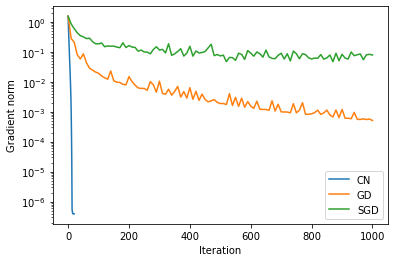

In [66]:
plt.plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
plt.plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
plt.plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.yscale('log')
plt.legend()

plt.show()

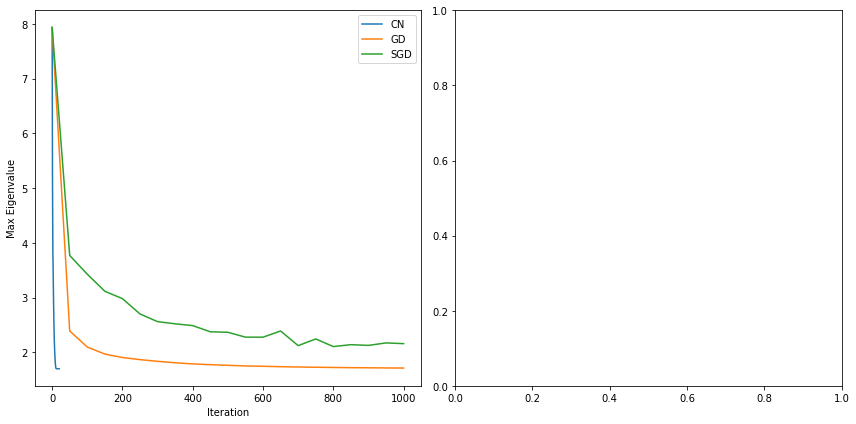

In [67]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_hessian_metrics["iter"], CN_hessian_metrics["lambda_1"], label="CN")
ax.plot(GD_hessian_metrics["iter"], GD_hessian_metrics["lambda_1"], label="GD")
ax.plot(SGD_hessian_metrics["iter"], SGD_hessian_metrics["lambda_1"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Max Eigenvalue")
ax.legend()

"""
ax = axes[1]
ax.plot(CN_hessian_metrics["iter"], CN_hessian_metrics["lambda_n"], label="CN")
ax.plot(GD_hessian_metrics["iter"], GD_hessian_metrics["lambda_n"], label="GD")
ax.plot(SGD_hessian_metrics["iter"], SGD_hessian_metrics["lambda_n"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Min Eigenvalue")
ax.legend()
"""

fig.tight_layout()
plt.show()

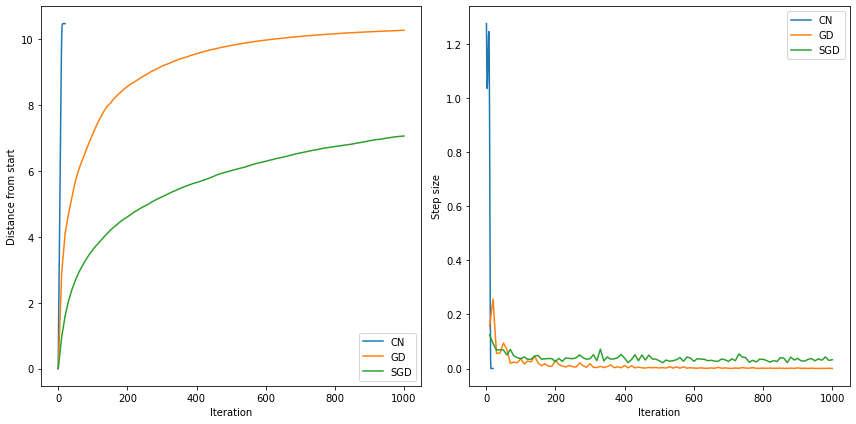

In [68]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_metrics["iter"], CN_metrics["dist_from_start"], label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["dist_from_start"], label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["dist_from_start"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Distance from start")
ax.legend()

ax = axes[1]
ax.plot(CN_metrics["iter"], CN_metrics["step_size"], label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["step_size"], label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["step_size"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Step size")
ax.legend()

fig.tight_layout()
plt.show()

### 1-hidden layer Neural Network

In [11]:
PATH = os.path.join(os.getcwd(), "saved_calc\\two_layers_NN")

if not os.path.isdir(PATH):
    os.makedirs(PATH)

In [12]:
new_dim = 20

net = MLP([new_dim, 10, 2], torch.relu)

loss_function = nn.CrossEntropyLoss()

def get_net():
    return copy.deepcopy(net)

def get_dataset():
    dataset = load_and_transform_mnist(new_dim)
    # tranforming labels to binary to reduce model size
    dataset["train_targets"] = transform_labels_to_binary(dataset["train_targets"])
    dataset["test_targets"] = transform_labels_to_binary(dataset["test_targets"])
    return dataset

In [13]:
model_dir = os.path.join(os.path.join(PATH, "CN"), "v1")
max_iters = 7000
print_every = 20
eval_every = 5
eval_hessian_every = 20
save_hessian_every = 1000
save_every=100
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

CN_trainer = AdaptiveCubicNewtonTrainer(get_net(), get_dataset(), loss_function, model_dir, Lipschitz_const, 
                            Lipschitz_const_min)
CN_trainer.load()
#CN_trainer.iter
_ = CN_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_hessian_every, save_every)#

 7,000: train loss =  0.137148, M = 65536.000, time = 24730.37 sec, lambda_n =    -2.319042


In [14]:
CN_metrics = get_metrics(CN_trainer)
CN_hessian_metrics = get_hessian_metrics(CN_trainer)

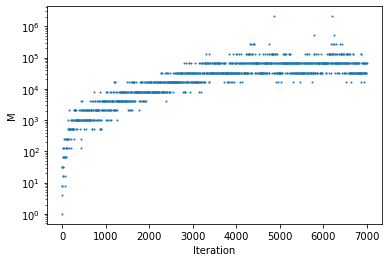

In [72]:
plt.scatter(CN_metrics["iter"], CN_metrics["M"], s=1)
plt.xlabel("Iteration")
plt.ylabel("M")
plt.yscale('log')
plt.show()

In [71]:
mask = [i in CN_hessian_metrics["iter"] for i in CN_metrics["iter"]]
M = CN_metrics["M"][mask][1:]
r = CN_metrics["step_size"][mask][1:]
lambda_n = np.array([spec[0] for spec in CN_trainer.hessian_metrics["spectrum"]])[1:]

psd_ness = lambda_n + M*r/2
print(f'min of eigenvalue of (H + Mr/2*I) over all observed iterations: {min(psd_ness): .5f}')

min of eigenvalue of (H + Mr/2*I) over all observed iterations:  0.25249


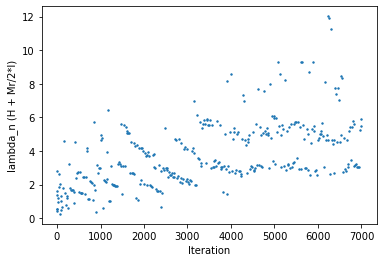

In [70]:
plt.scatter(CN_hessian_metrics["iter"][1:], psd_ness, s=2)
plt.xlabel("Iteration")
plt.ylabel("lambda_n (H + Mr/2*I)")
plt.show()

In [16]:
CN_trainer.save()

In [89]:
#visualize_hessians_evolution(CN_trainer)

In [90]:
#visualize_spectrum_evolution(CN_trainer)

In [19]:
model_dir = os.path.join(os.path.join(PATH, "GD"), "v1")
max_iters = 20000
print_every = 100
eval_every = 10
eval_hessian_every = 100
save_hessian_every = 1000
save_every = 1000
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

GD_trainer = AdaptiveGDTrainer(get_net(), get_dataset(), loss_function, model_dir, Lipschitz_const, 
                            Lipschitz_const_min)

GD_trainer.load()
GD_trainer.iter
#_ = GD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_hessian_every, save_every)

17000

In [122]:
GD_trainer.save()

In [91]:
#visualize_hessians_evolution(GD_trainer)

In [92]:
#visualize_spectrum_evolution(GD_trainer)

In [20]:
model_dir = os.path.join(os.path.join(PATH, "SGD"), "v1")
max_iters = 30000
print_every = 100
eval_every = 50
eval_hessian_every = 200
save_hessian_every = 1000
save_every = 5000
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
b_size = 128

SGD_trainer = CustomTrainer(get_net(), get_dataset(), loss_function, model_dir, optim_class, optim_params, b_size)

SGD_trainer.load()
SGD_trainer.iter
#_ = SGD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_hessian_every, save_every)

35000

lr decay after 20000 iters by factor of 5

lr decay after 30000 iters by factor of 5

In [106]:
SGD_trainer.save()

In [118]:
#SGD_trainer.optimizer.param_groups[0]['lr'] /= 5

In [93]:
#visualize_hessians_evolution(SGD_trainer)

In [94]:
#visualize_spectrum_evolution(SGD_trainer)

In [22]:
CN_metrics = get_metrics(CN_trainer)
GD_metrics = get_metrics(GD_trainer)
SGD_metrics = get_metrics(SGD_trainer)
CN_hessian_metrics = get_hessian_metrics(CN_trainer)
GD_hessian_metrics = get_hessian_metrics(GD_trainer)
SGD_hessian_metrics = get_hessian_metrics(SGD_trainer)

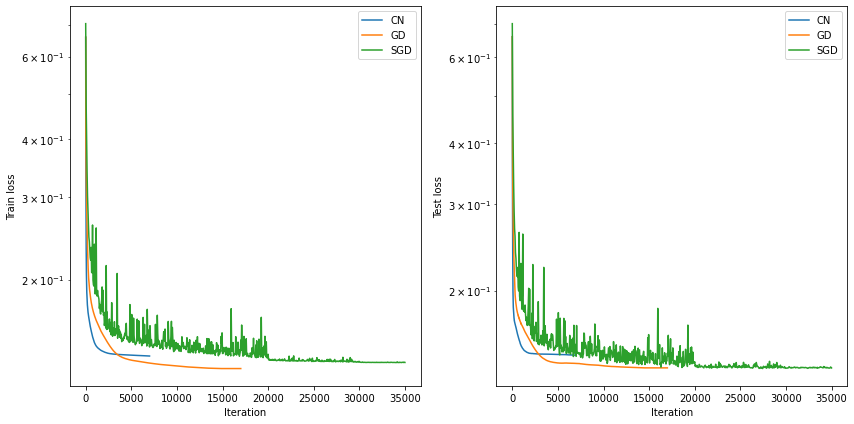

In [23]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["train_loss"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Train loss")
ax.set_yscale('log')
ax.legend()

ax = axes[1]
ax.plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["test_loss"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Test loss")
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
plt.show()

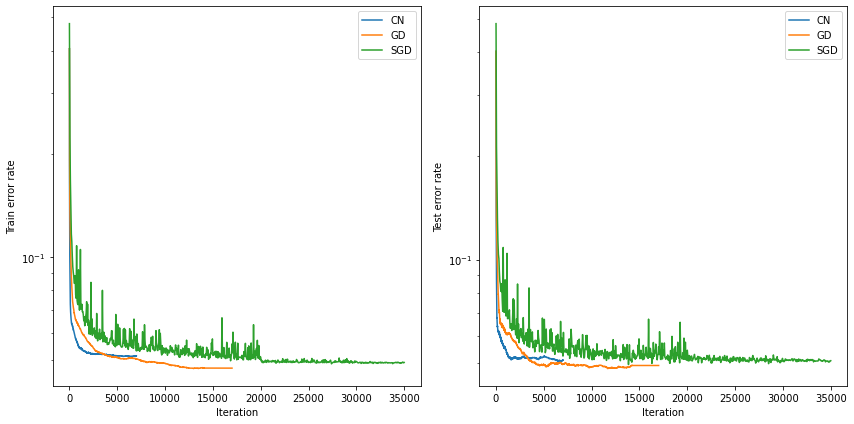

In [24]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax.plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax.plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Train error rate")
ax.set_yscale('log')
ax.legend()

ax = axes[1]
ax.plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax.plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax.plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Test error rate")
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
plt.show()

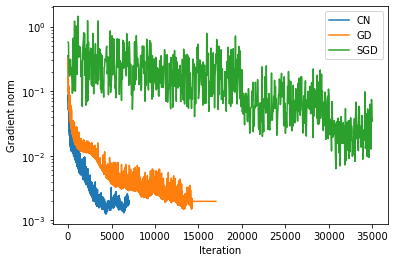

In [25]:
plt.plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
plt.plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
plt.plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.yscale('log')
plt.legend()

plt.show()

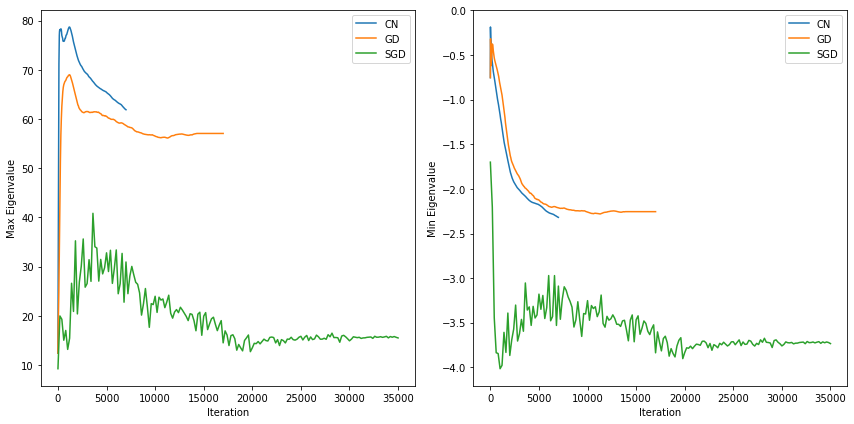

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_hessian_metrics["iter"], CN_hessian_metrics["lambda_1"], label="CN")
ax.plot(GD_hessian_metrics["iter"], GD_hessian_metrics["lambda_1"], label="GD")
ax.plot(SGD_hessian_metrics["iter"], SGD_hessian_metrics["lambda_1"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Max Eigenvalue")
ax.legend()

ax = axes[1]
ax.plot(CN_hessian_metrics["iter"], CN_hessian_metrics["lambda_n"], label="CN")
ax.plot(GD_hessian_metrics["iter"], GD_hessian_metrics["lambda_n"], label="GD")
ax.plot(SGD_hessian_metrics["iter"], SGD_hessian_metrics["lambda_n"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Min Eigenvalue")
ax.legend()

fig.tight_layout()
plt.show()

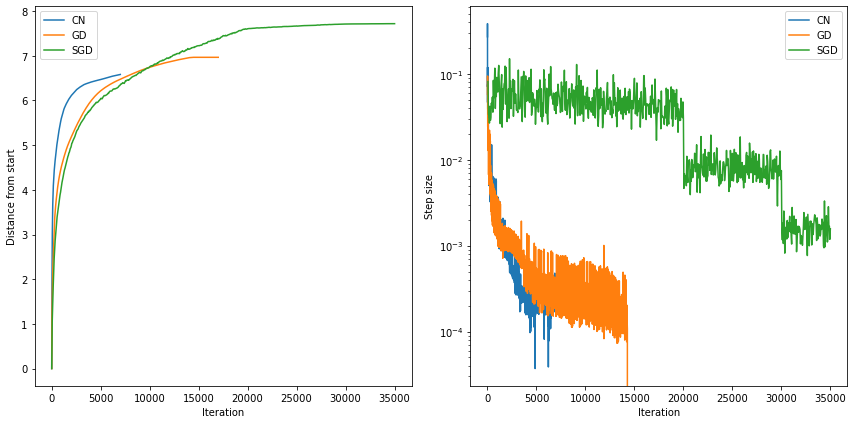

In [29]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

ax = axes[0]
ax.plot(CN_metrics["iter"], CN_metrics["dist_from_start"], label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["dist_from_start"], label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["dist_from_start"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Distance from start")
ax.legend()

ax = axes[1]
ax.plot(CN_metrics["iter"], CN_metrics["step_size"], label="CN")
ax.plot(GD_metrics["iter"], GD_metrics["step_size"], label="GD")
ax.plot(SGD_metrics["iter"], SGD_metrics["step_size"], label="SGD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Step size")
ax.set_yscale('log')
ax.legend()

fig.tight_layout()
plt.show()